## Семинар 11
# Тема:  Работа с выбросами

Выбросы – это точки данных в признаке, которые отклоняются от нормы значений этого признака.

Нет однозначного способа понять, что перед нами выброс. Разные способы обнаружения выбросов возвращают разные точки в качестве выбросов, и эти точки пересекаются лишь частично.


**Способы обнаружения выбросов:**

1. Поиск по порогу.

Этот способ представляет собой погружение в предметную область и понимание того, какие значения признаки могут принимать, а какие - не могут.

2. Обнаружение и обработка выбросов, используя метод **IQR** (interquartile range, межквартильное расстояние).

Строим `boxplot` и все значения вне "усов" считаем выбросами. Левая линия ящика обозначает первый квартиль (25-й перцентиль q25), а правая линия ящика обозначает третий квартиль (75-й перцентиль q75). Границы "усов" определяются так:

нижняя граница - это минимальное значение признака между q25 - (1.5*iqr) и q75 + (1.5*iqr),

верхняя граница  - это максимальное значение признака между q25 - (1.5*iqr) и q75 + (1.5*iqr),

где  iqr = q75-q25

Метод межквартильного расстояния выделяет как выбросы все значения, находящиеся за пределами "усов".
   
3.  Поиск по отклонению (z-score)
  
Поиск по отклонению основан на поиске значения, на которое отклоняется данная точка от среднего. Делается это с помощью z-score, то есть, расстояния (измеряемого в количестве стандартных отклонений) от среднего значения точек.  

4. Поиск выбросов с помощью методов машинного обучения

Например, изолирующий лес (Isolation Forest)

**Способы борьбы с выбросами:**

- Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем).
- Заменять выбросы разными методами (использовать знания по предметной области, медианы, средние значения, np.clip и т.д.)
- Делать/не делать дополнительную фичу.
- Ничего не делать

Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.ensemble import IsolationForest

### 1. Загрузите датасет apartament.csv и выведите первые 5 строк.

In [2]:
data = pd.read_csv("/content/apartment.csv")
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


### 2. Создайте копию загруженного датафрейма и выведите информацию о данных.

In [3]:
data_copy = data.copy()
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### 3. Осуществите обнаружение выбросов **по порогу** для признака `Rooms`. Для этого используйте следующие знания по предметной области: количество комнат не может быть 0 и больше 6. Выведите индексы тех наблюдений, где количество комнат не удовлетворяет этим условиям. Подсчитайте их количество.

In [4]:
data_copy["Rooms"].value_counts()

,count
Rooms,
2.0,3880
1.0,3705
3.0,2235
4.0,150
5.0,18
0.0,8
10.0,2
19.0,1
6.0,1


In [5]:
mask1 = (data_copy["Rooms"] <= 0) | (data_copy["Rooms"] > 6)
data_copy.loc[mask1, "Rooms"]

,Rooms
2004,10.0
2194,0.0
2728,10.0
3780,0.0
5894,0.0
6088,19.0
6401,0.0
7644,0.0
7929,0.0
9767,0.0


In [6]:
rooms_outlier = data_copy.loc[mask1, "Rooms"].index
rooms_outlier

Index([2004, 2194, 2728, 3780, 5894, 6088, 6401, 7644, 7929, 9767, 9869], dtype='int64')

In [7]:
len(rooms_outlier)

11

### 4. Обработайте выбросы в пизнаке Rooms, например, так: если число комнат равно нулю, то замените его на 1, если больше 6 - на 6. Добавьте к исходному датасету признак Rooms_outlier, в котором на местах с выбросами стоят 1, а остальные - 0.

In [8]:
data_copy.loc[data_copy['Rooms'] == 0, 'Rooms'] = 1
data_copy.loc[data_copy['Rooms'] > 6, 'Rooms'] = 6
data_copy['Rooms'].value_counts()

,count
Rooms,
2.0,3880
1.0,3713
3.0,2235
4.0,150
5.0,18
6.0,4


In [9]:
data_copy['Rooms_outlier'] = 0
data_copy.loc[rooms_outlier, 'Rooms_outlier'] = 1
data_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [10]:
data_copy['Rooms_outlier'].value_counts()

,count
Rooms_outlier,
0,9989
1,11


### 5. Для признака Ecology_1 осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально определите наличие выбросов.

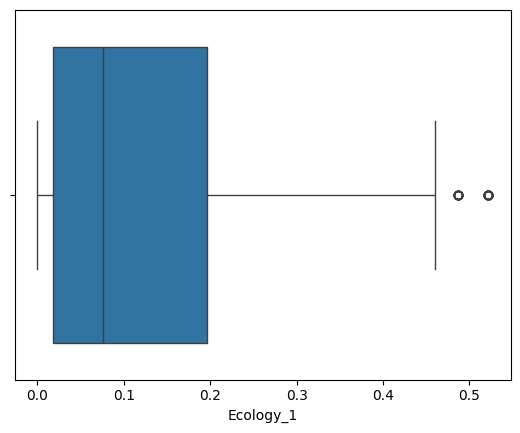

In [11]:
plt.figure()
sns.boxplot(x=data_copy['Ecology_1'], )
plt.show()

### 6. Используя функцию outliers_iqr определите индексы наблюдений с выбросами. Подсчитайте их количество.

In [12]:
def outliers_iqr(x):
    q25 = x.quantile(.25)
    q75 = x.quantile(.75)
    iqr = q75 - q25
    lower_bound = q25 - iqr * 1.5
    upper_bound = q75 + iqr * 1.5
    outliers_index = x[(x > upper_bound) | (x < lower_bound)].index
    min_border = x[(x <= upper_bound) & (x >= lower_bound)].min()
    max_border = x[(x <= upper_bound) & (x >= lower_bound)].max()
    return outliers_index, min_border, max_border

In [13]:
outliers_index, min_border, max_border = outliers_iqr(data_copy['Ecology_1'])
min_border, max_border

(0.0, 0.460556389)

In [14]:
outliers_index

Index([ 201,  516,  704,  719,  798,  802, 1041, 1051, 1351, 1386, 1772, 2073,
       2080, 2135, 2226, 2446, 2495, 2536, 3049, 3305, 3511, 4063, 4089, 4265,
       4373, 4519, 4561, 4719, 4985, 5082, 5200, 5244, 5311, 5401, 5420, 5439,
       5777, 5807, 5903, 6140, 6199, 6231, 6426, 7375, 7450, 7609, 7836, 8223,
       8240, 8308, 8362, 8435, 8587, 8629, 9188, 9347, 9368, 9371, 9627, 9958,
       9985],
      dtype='int64')

In [15]:
len(outliers_index)

61

### 7. Обработайте выбросы в пизнаке Ecology_1, например, так: замените их на np.nan и далее удалите наблюдения с пропусками в пизнаке Ecology_1.

In [16]:
data_copy.loc[outliers_index, 'Ecology_1'] = np.nan
data_copy['Ecology_1'].isna().sum()

np.int64(61)

In [17]:
from re import sub
data_copy = data_copy.dropna(subset = 'Ecology_1', axis=0, ignore_index=True)
data_copy.shape

(9939, 21)

### 8. Снова постройте "ящик с усами" для этого признака и убедитесь, что выбросов больше нет.

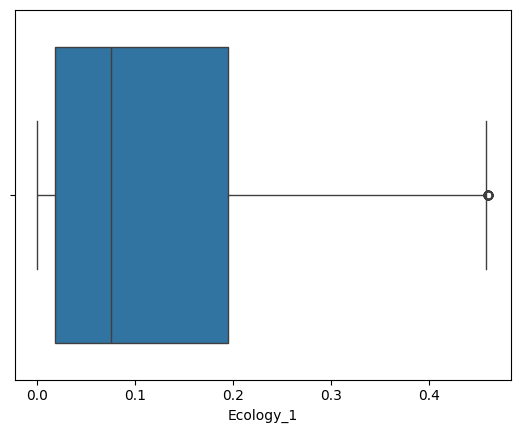

In [18]:
plt.figure()
sns.boxplot(x=data_copy['Ecology_1'], )
plt.show()

### 9. Для признака Square осуществите обнаружение выбросов методом **z-score**. Для этого используйте функцию outliers_z_score и определите индексы наблюдений с выбросами. Подсчитайте их количество.

In [19]:
def outliers_z_score(x, threshold=3):
    mean = np.mean(x)
    std = np.std(x)
    z_scores = [(element - mean) / std for element in x]
    print(len(z_scores))
    return np.where(np.abs(z_scores) > threshold)[0]

In [20]:
index = outliers_z_score(data_copy['Square'])
index

9939


array([ 136,  285,  348,  402,  442,  510,  597,  690,  722,  726,  860,
       1078, 1164, 1343, 1439, 1449, 1596, 1604, 1682, 1719, 1765, 1840,
       1895, 1938, 1969, 2026, 2030, 2055, 2073, 2252, 2310, 2321, 2378,
       2388, 2414, 2499, 2645, 2772, 2945, 2992, 3102, 3163, 3185, 3934,
       4419, 4586, 4649, 4967, 5002, 5226, 5227, 5251, 5375, 5440, 5550,
       5595, 5728, 5806, 5953, 5991, 6060, 6168, 6301, 6407, 6457, 6506,
       6575, 6786, 6866, 6963, 6967, 7101, 7130, 7353, 7598, 7664, 7832,
       7964, 7997, 8008, 8081, 8414, 8623, 8818, 8983, 9050, 9174, 9252,
       9475, 9604, 9708, 9787, 9818])

In [21]:
len(index)

93

### 10.  Обработайте выбросы в пизнаке Square заменив их медианным значением. Добавьте к исходному датасету признак Square_outlier, в котором на местах с выбросами стоят 1, а остальные - 0.

In [22]:
data_copy['Square_outlier'] = 0
data_copy.loc[index, 'Square_outlier'] = 1
data_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.102962,0,0


In [23]:
data_copy['Square_outlier'].value_counts()

,count
Square_outlier,
0,9846
1,93


In [24]:
np.median(data_copy['Square'])

np.float64(52.57313255721929)

In [25]:
data_copy.loc[index, 'Square'] = np.median(data_copy['Square'])
data_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.102962,0,0


# Задания для самостоятельного выполнения
Продолжите работу с рассматриваемым датасетом `apartment.csv`.
1. Осуществите обнаружение выбросов **по порогу** для признака `KitchenSquare`. Для этого используйте следующие знания по предметной области: площадь кухни не может быть меньше 3 и больше 13 метров. Выведите индексы тех наблюдений, где это условие не выполняется. Подсчитайте их количество.
2. Обработайте выбросы в пизнаке `KitchenSquare`, например, так: площадь кухни меньше 3, то замените его на 3, если больше 13 - на медианное значение. Добавьте к исходному датасету признак `KitchenSquare_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0.
3. Осуществите обнаружение выбросов **по порогу** для признака `Floor`. Для этого используйте следующие знания по предметной области: этаж квартиры `Floor` не должен быть больше этажности дома `HouseFloor`. Выведите индексы тех наблюдений, где это условие не выполняется. Подсчитайте их количество.
4. Обработайте выбросы в пизнаке `Floor`, например, так: замените этаж квартиры `Floor` на случайный от 0 (подвал) до числа этажей в доме `HouseFloor`. Добавьте к исходному датасету признак `Floor_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0.
5. Для признака `Social_1` осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально убедитесь, что выбросов нет.
6. Для признака `Social_2` осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально определите наличие выбросов. Используя функцию `outliers_iqr` определите индексы наблюдений с выбросами. Подсчитайте их количество.
7. Обработайте выбросы в пизнаке `Social_2`, например, так: замените их на np.nan и далее удалите наблюдения с пропусками.
8. Для признака `Social_3` осуществите обнаружение выбросов методом **z-score**. Для этого используйте функцию `outliers_z_score` и определите индексы наблюдений с выбросами. Подсчитайте их количество.
9.  Обработайте выбросы в пизнаке `Social_3` заменив их медианным значением. Добавьте к исходному датасету признак `Social_3_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0.
10. Осуществите обнаружение выбросов для признака `HouseYear` используя модель IsolationForest(contamination = 0.1, random_state = 42).

1. Осуществите обнаружение выбросов по порогу для признака KitchenSquare. Для этого используйте следующие знания по предметной области: площадь кухни не может быть меньше 3 и больше 13 метров. Выведите индексы тех наблюдений, где это условие не выполняется. Подсчитайте их количество.

In [26]:
mask_kitchenSquare = (data_copy["KitchenSquare"] < 3) | (data_copy["Rooms"] > 13)
data_copy.loc[mask_kitchenSquare, "KitchenSquare"]

,KitchenSquare
3,1.0
8,1.0
9,1.0
18,1.0
19,1.0
...,...
9922,1.0
9923,1.0
9929,2.0
9930,0.0


In [27]:
kitchen_outlier = data_copy.loc[mask_kitchenSquare, "KitchenSquare"].index
kitchen_outlier

Index([   3,    8,    9,   18,   19,   20,   24,   25,   26,   30,
       ...
       9909, 9915, 9918, 9919, 9921, 9922, 9923, 9929, 9930, 9932],
      dtype='int64', length=3160)

In [28]:
len(kitchen_outlier)

3160

2. Обработайте выбросы в пизнаке KitchenSquare, например, так: площадь кухни меньше 3, то замените его на 3, если больше 13 - на медианное значение. Добавьте к исходному датасету признак KitchenSquare_outlier, в котором на местах с выбросами стоят 1, а остальные - 0.

In [29]:
data_copy.loc[data_copy['KitchenSquare'] < 3, 'KitchenSquare'] = 3
data_copy.loc[data_copy['KitchenSquare'] > 13, 'KitchenSquare'] = np.median(data_copy['KitchenSquare'])
data_copy.loc[mask_kitchenSquare, "KitchenSquare"]

,KitchenSquare
3,3.0
8,3.0
9,3.0
18,3.0
19,3.0
...,...
9922,3.0
9923,3.0
9929,3.0
9930,3.0


In [30]:
data_copy['KitchenSquare_outlier'] = 0
data_copy.loc[mask_kitchenSquare, 'KitchenSquare_outlier'] = 1
data_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.871089,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,0,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,B,343995.102962,0,0,0


In [31]:
data_copy['KitchenSquare_outlier'].value_counts()

,count
KitchenSquare_outlier,
0,6779
1,3160


3. Осуществите обнаружение выбросов по порогу для признака Floor. Для этого используйте следующие знания по предметной области: этаж квартиры Floor не должен быть больше этажности дома HouseFloor. Выведите индексы тех наблюдений, где это условие не выполняется. Подсчитайте их количество.

In [35]:
mask_floors = (data_copy["Floor"] > data_copy["HouseFloor"])
data_copy.loc[mask_floors, "Floor"]

,Floor
17,6
19,16
21,11
24,2
25,18
...,...
9900,15
9908,18
9910,18
9915,18


In [33]:
len(mask_floors)

9939

4. Обработайте выбросы в пизнаке Floor, например, так: замените этаж квартиры Floor на случайный от 0 (подвал) до числа этажей в доме HouseFloor. Добавьте к исходному датасету признак Floor_outlier, в котором на местах с выбросами стоят 1, а остальные - 0.

In [38]:
data_copy["Floor"] = np.random.randint(0, data_copy['HouseFloor'] + 1)

In [39]:
data_copy['Floor_outlier'] = 0
data_copy.loc[mask_floors, 'Floor_outlier'] = 1
data_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,Floor_outlier
0,11809,27,3.0,115.027311,NaN,10.0,10,10.0,2014,0.075424,...,0,NaN,0,0,B,305018.871089,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,5,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,7,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,0,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,12,22.0,1977,0.007122,...,0,NaN,0,1,B,168106.007630,0,0,1,0
4,13866,94,2.0,64.285067,38.562517,9.0,4,16.0,1972,0.282798,...,2,NaN,0,6,B,343995.102962,0,0,0,0


In [41]:
data_copy['Floor_outlier'].value_counts()

,count
Floor_outlier,
0,8123
1,1816


5. Для признака Social_1 осуществите обнаружение выбросов методом IQR. Для этого постройте "ящик с усами" для этого признака и визуально убедитесь, что выбросов нет.

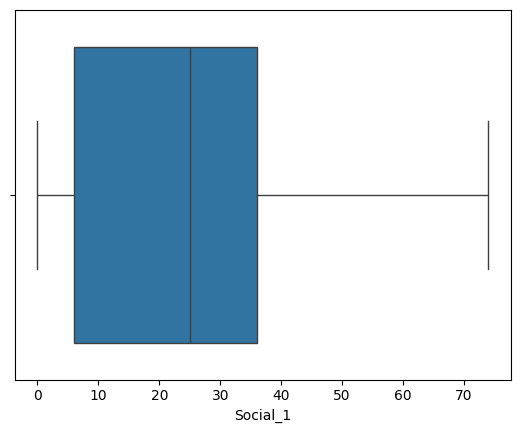

In [42]:
plt.figure()
sns.boxplot(x=data_copy['Social_1'])
plt.show()

6. Для признака Social_2 осуществите обнаружение выбросов методом IQR. Для этого постройте "ящик с усами" для этого признака и визуально определите наличие выбросов. Используя функцию outliers_iqr определите индексы наблюдений с выбросами. Подсчитайте их количество.

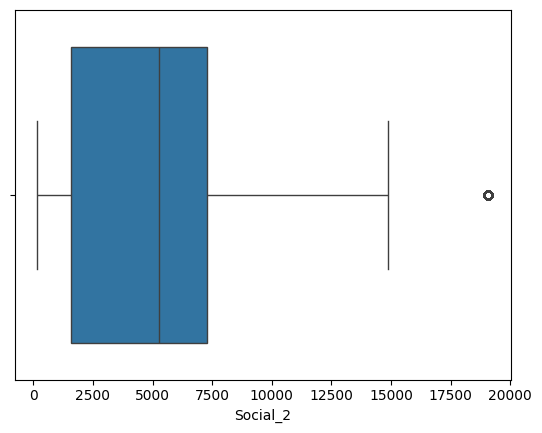

In [43]:
plt.figure()
sns.boxplot(x=data_copy['Social_2'])
plt.show()

In [44]:
outliers_index, min_border, max_border = outliers_iqr(data_copy['Social_2'])
min_border, max_border

(168, 14892)

In [45]:
outliers_index

Index([ 237,  299,  338,  359,  402,  422,  676,  705,  745,  782,
       ...
       9536, 9582, 9619, 9625, 9672, 9758, 9788, 9797, 9834, 9924],
      dtype='int64', length=176)

In [46]:
len(outliers_index)

176

7. Обработайте выбросы в пизнаке Social_2, например, так: замените их на np.nan и далее удалите наблюдения с пропусками.

In [47]:
data_copy.loc[outliers_index, 'Social_2'] = np.nan
data_copy['Social_2'].isna().sum()

np.int64(176)

In [48]:
data_copy = data_copy.dropna(subset = 'Social_2', axis=0, ignore_index=True)
data_copy.shape

(9763, 24)

8. Для признака Social_3 осуществите обнаружение выбросов методом z-score. Для этого используйте функцию outliers_z_score и определите индексы наблюдений с выбросами. Подсчитайте их количество.

In [49]:
index = outliers_z_score(data_copy['Social_3'])
index

9763


array([  42,   51,  106,  109,  160,  191,  286,  291,  327,  397,  404,
        478,  479,  559,  566,  575,  582,  624,  642,  726,  730,  738,
        748,  752,  760,  782,  785,  803,  852,  935,  936,  989, 1001,
       1009, 1053, 1058, 1080, 1115, 1118, 1122, 1140, 1154, 1179, 1203,
       1250, 1276, 1333, 1452, 1518, 1536, 1546, 1604, 1634, 1639, 1661,
       1691, 1715, 1722, 1727, 1777, 1822, 1823, 1831, 1836, 1905, 1921,
       1932, 1968, 2016, 2024, 2040, 2059, 2063, 2099, 2130, 2150, 2179,
       2183, 2196, 2236, 2240, 2283, 2327, 2330, 2357, 2386, 2449, 2480,
       2498, 2506, 2566, 2581, 2608, 2622, 2627, 2633, 2638, 2639, 2667,
       2696, 2715, 2720, 2747, 2766, 2798, 2800, 2818, 2858, 2867, 2925,
       2950, 3003, 3031, 3051, 3123, 3178, 3223, 3239, 3292, 3375, 3382,
       3393, 3450, 3481, 3488, 3520, 3526, 3585, 3620, 3693, 3703, 3714,
       3737, 3741, 3846, 3914, 3930, 3984, 3986, 4021, 4055, 4134, 4148,
       4151, 4167, 4178, 4320, 4346, 4350, 4363, 45

In [50]:
len(index)

340

9. Обработайте выбросы в пизнаке Social_3 заменив их медианным значением. Добавьте к исходному датасету признак Social_3_outlier, в котором на местах с выбросами стоят 1, а остальные - 0.

In [51]:
data_copy['Social_3_outlier'] = 0
data_copy.loc[index, 'Social_3_outlier'] = 1
data_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,Floor_outlier,Social_3_outlier
0,11809,27,3.0,115.027311,NaN,10.0,10,10.0,2014,0.075424,...,NaN,0,0,B,305018.871089,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,5,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,7,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,12,22.0,1977,0.007122,...,NaN,0,1,B,168106.007630,0,0,1,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,4,16.0,1972,0.282798,...,NaN,0,6,B,343995.102962,0,0,0,0,0


In [52]:
data_copy['Social_3_outlier'].value_counts()

,count
Social_3_outlier,
0,9423
1,340


In [53]:
np.median(data_copy['Social_3'])

np.float64(2.0)

In [54]:
data_copy.loc[index, 'Social_3'] = np.median(data_copy['Social_3'])
data_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,Floor_outlier,Social_3_outlier
0,11809,27,3.0,115.027311,NaN,10.0,10,10.0,2014,0.075424,...,NaN,0,0,B,305018.871089,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,5,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,7,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,12,22.0,1977,0.007122,...,NaN,0,1,B,168106.007630,0,0,1,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,4,16.0,1972,0.282798,...,NaN,0,6,B,343995.102962,0,0,0,0,0


10. Осуществите обнаружение выбросов для признака HouseYear используя модель IsolationForest(contamination = 0.1, random_state = 42).

In [57]:
X = data_copy[['HouseYear']]

In [58]:
model = IsolationForest(contamination=0.1, random_state=42)
outliers = model.fit_predict(X)

In [59]:
outliers

array([ 1,  1,  1, ..., -1,  1,  1])

In [62]:
data_copy['HouseYear'] = (outliers == -1).astype(int)  # Преобразуем в 1/0
data_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,Floor_outlier,Social_3_outlier,HouseYear_outlier
0,11809,27,3.0,115.027311,NaN,10.0,10,10.0,0,0.075424,...,0,0,B,305018.871089,0,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,5,8.0,0,0.118537,...,1,0,B,177734.553407,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,7,17.0,0,0.025609,...,3,1,B,282078.720850,0,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,12,22.0,0,0.007122,...,0,1,B,168106.007630,0,0,1,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,4,16.0,0,0.282798,...,0,6,B,343995.102962,0,0,0,0,0,0
